In [1]:
from torch.utils.data import DataLoader, Subset
from torchvision import models,transforms
import pandas as pd
import numpy as np
import os
from PIL import Image
from typing import Tuple, List
import torch
from torch import optim,nn
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt

from dataset import MaskDataset, AddGaussianNoise
from models import get_pre_trained

data_dir = '../../input/data/train'

In [2]:
torch.cuda.empty_cache()

In [3]:
# model_name = 'densenet161'
model_name = 'resnet18'
num_classes = 18
# Initialize the model for this run
model = get_pre_trained(model_name, feature_extract = False, pretrained = True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model.to(device)

In [4]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
#                                       transforms.RandomRotation(degrees = 5),
#                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
#                                       transforms.Resize((512, 384), Image.BILINEAR
#                                       transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(norm_mean, norm_std),
#                                       AddGaussianNoise()
                                     ])
val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

dataset = MaskDataset(data_dir=data_dir,transforms=train_transform, adj_csv = True, val_ratio=0.15, up_sampling = 0, augment = 0)
batch_size = 32
train_set, val_set = dataset.split_dataset()
use_cuda = torch.cuda.is_available()

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=use_cuda,
    drop_last=True,
)

val_loader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=use_cuda,
    drop_last=True,
)

Data split completed: val_ratio=0.15
n_train=16065, n_val=2835


In [5]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 512, 384])

In [6]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def train(model, train_loader, criterion, optimizer, epoch):
    save_dir = os.path.join(os.getcwd(), 'save')
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [8]:
def validate(model, val_loader, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [9]:
MODEL_PATH = '../model' + '/' + model_name
os.makedirs(MODEL_PATH, exist_ok=True)
epoch_num = 3
best_val_acc = 0
total_loss_train, total_acc_train = [],[]
total_loss_val, total_acc_val = [],[]
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)
for epoch in tqdm(range(1, epoch_num+1)):
    if epoch>=2:
        for name, param in model.named_parameters():
            if name.startswith('fc') or name.startswith('classifier'):
                param.requires_grad = True
            else:
                param.requires_grad = False
    loss_train, acc_train = train(model, train_loader, criterion, optimizer, epoch)
    loss_val, acc_val = validate(model, val_loader, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, f"{model_name}_best.pt"))
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/3 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 502], [train loss 0.95802], [train acc 0.73031]
[epoch 1], [iter 200 / 502], [train loss 0.65696], [train acc 0.80953]
[epoch 1], [iter 300 / 502], [train loss 0.52952], [train acc 0.84198]
[epoch 1], [iter 400 / 502], [train loss 0.45545], [train acc 0.86172]
[epoch 1], [iter 500 / 502], [train loss 0.40122], [train acc 0.87750]
------------------------------------------------------------
[epoch 1], [val loss 0.17163], [val acc 0.94283]
------------------------------------------------------------


 33%|███▎      | 1/3 [02:52<05:45, 172.87s/it]

*****************************************************
best record: [epoch 1], [val loss 0.17163], [val acc 0.94283]
*****************************************************
[epoch 2], [iter 100 / 502], [train loss 0.14380], [train acc 0.95781]
[epoch 2], [iter 200 / 502], [train loss 0.13936], [train acc 0.95750]
[epoch 2], [iter 300 / 502], [train loss 0.13984], [train acc 0.95792]
[epoch 2], [iter 400 / 502], [train loss 0.13758], [train acc 0.95813]
[epoch 2], [iter 500 / 502], [train loss 0.13795], [train acc 0.95731]
------------------------------------------------------------
[epoch 2], [val loss 0.13839], [val acc 0.95277]
------------------------------------------------------------


 67%|██████▋   | 2/3 [05:07<02:30, 150.26s/it]

*****************************************************
best record: [epoch 2], [val loss 0.13839], [val acc 0.95277]
*****************************************************
[epoch 3], [iter 100 / 502], [train loss 0.12833], [train acc 0.95969]
[epoch 3], [iter 200 / 502], [train loss 0.12864], [train acc 0.96203]
[epoch 3], [iter 300 / 502], [train loss 0.12572], [train acc 0.96208]
[epoch 3], [iter 400 / 502], [train loss 0.12337], [train acc 0.96281]
[epoch 3], [iter 500 / 502], [train loss 0.12567], [train acc 0.96131]
------------------------------------------------------------
[epoch 3], [val loss 0.13152], [val acc 0.95419]
------------------------------------------------------------


100%|██████████| 3/3 [07:21<00:00, 147.19s/it]

*****************************************************
best record: [epoch 3], [val loss 0.13152], [val acc 0.95419]
*****************************************************


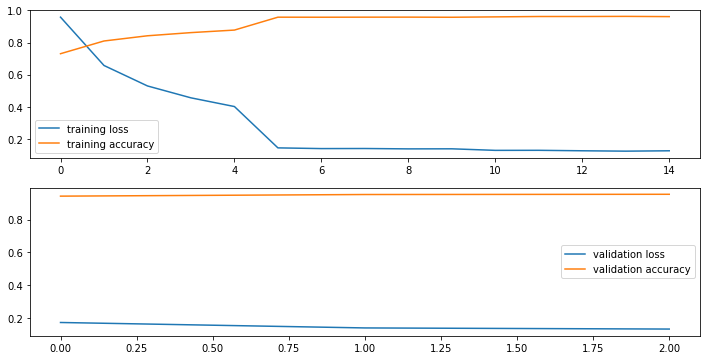

In [10]:
fig = plt.figure(num = 2, figsize = (12,6))
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.legend()
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.legend()
plt.show()